## Training Model

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(82, 82, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Define directories and parameters
train_data_dir = './helmet_detection/train'
validation_data_dir = './helmet_detection/validations'
nb_train_samples = 3202
nb_validation_samples = 220
epochs = 50
batch_size = 12

# Create data generators with augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(82, 82),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(82, 82),
        batch_size=batch_size,
        class_mode='binary')

Found 3202 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 activation_9 (Activation)   (None, 80, 80, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 32)        9248      
                                                                 
 activation_10 (Activation)  (None, 38, 38, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 19, 19, 32)        0         
 g2D)                                                 

In [18]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min')
mcp_save = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')
# train the network
print("[INFO] training network...")
H = model.fit_generator(train_generator, 
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=30,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size,
                            callbacks=[reduce_lr_loss],verbose=1)
model.save("./model_detect.h5")

[INFO] training network...
Epoch 1/30
266/266 [==============================] - 4s 15ms/step - loss: 0.1030 - accuracy: 0.9602 - val_loss: 0.2371 - val_accuracy: 0.9444 - lr: 1.0000e-05
Epoch 2/30
266/266 [==============================] - 4s 15ms/step - loss: 0.0959 - accuracy: 0.9630 - val_loss: 0.2240 - val_accuracy: 0.9398 - lr: 1.0000e-05
Epoch 3/30
266/266 [==============================] - 4s 15ms/step - loss: 0.0941 - accuracy: 0.9649 - val_loss: 0.2182 - val_accuracy: 0.9398 - lr: 1.0000e-05
Epoch 4/30
266/266 [==============================] - 4s 15ms/step - loss: 0.0950 - accuracy: 0.9627 - val_loss: 0.2220 - val_accuracy: 0.9398 - lr: 1.0000e-05
Epoch 5/30
266/266 [==============================] - 4s 15ms/step - loss: 0.0958 - accuracy: 0.9655 - val_loss: 0.2329 - val_accuracy: 0.9352 - lr: 1.0000e-05
Epoch 6/30
266/266 [==============================] - 4s 15ms/step - loss: 0.0920 - accuracy: 0.9646 - val_loss: 0.2169 - val_accuracy: 0.9444 - lr: 1.0000e-05
Epoch 7/30
26

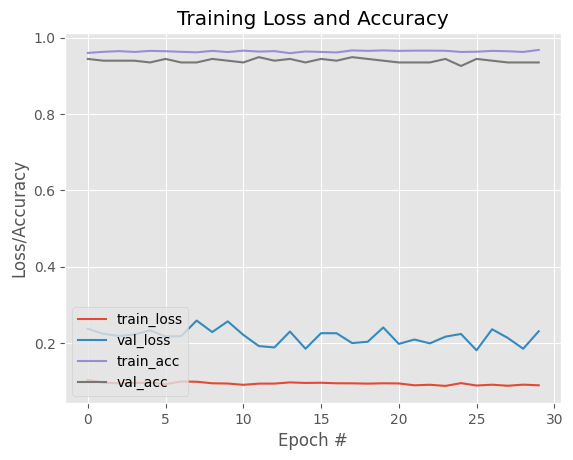

In [27]:
import matplotlib.pyplot as plt 
import numpy as np
plt.style.use("ggplot")
plt.figure()
N = 30
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("./fig.png")

# Predictions/Results

In [19]:
from keras.preprocessing import image
from keras.models import load_model
from PIL import Image
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [20]:
model = load_model('./model_detect.h5') #new_4-24-1(0.10 0.96 0.23 0.93).h5

In [21]:
import shutil
import os

def copy_folder_by_name(source_folder, destination_folder, folder_name = None):
    # Lấy danh sách các thư mục và tệp trong thư mục nguồn
    items = os.listdir(source_folder)

    # Lặp qua từng phần tử trong thư mục nguồn
    for item in items:
        # Tạo đường dẫn đầy đủ đến mục này
        item_path = os.path.join(source_folder, item)

        # Kiểm tra nếu đây là một thư mục và có tên trùng khớp với tên cần sao chép
        if os.path.isdir(item_path) and item == folder_name:
            # Tạo đường dẫn đích cho thư mục cần sao chép
            destination_path = os.path.join(destination_folder, item)
            
            # Sao chép thư mục và nội dung của nó đến thư mục đích
            shutil.copytree(item_path, destination_path)
            print(f"Đã sao chép thành công thư mục {item} đến {destination_folder}")
            break
    else:
        print(f"Không tìm thấy thư mục có tên {folder_name} trong {source_folder}")


In [23]:
import glob
from PIL import Image
from keras.preprocessing import image
import os

# Đường dẫn thư mục nguồn và đích
source_directory = './cluster'  # Thay đổi đường dẫn này
destination_directory = './bike_no_helmet/'  # Thay đổi đường dẫn này
user_preds = []
h1 = 0
h2 = 0
user_folders = glob.glob("./cluster/bike_*")
for user in user_folders:
    uname = user.split('/')[-1]
    print(uname,end=' => ')
    cropped_files = glob.glob(user+'/cropped/*')
    print("Cropped: ", cropped_files)
    print('[',end='')
    res = 'no_helmet'
    for file in cropped_files:
        im = image.load_img(file)
        width,height = im.size
        f, e = os.path.splitext(file)
        im = im.crop((1, 1, width, height//4))
        imResize = im.resize((82,82), Image.Resampling.LANCZOS)
        imResize = imResize.convert('RGB')
        #imResize.save(f+'_1.png', 'PNG', quality=100)
        img = image.img_to_array(imResize)
        im_f = np.expand_dims(img,axis=0)
        result = model.predict(im_f)
        if(result[0][0]>=0.6):
            res='helmet'
        print(result[0][0],end=' ')
    print(']',end=' => ')
    print(res,end='\n')
    if (res == 'no_helmet'):
        copy_folder_by_name(source_directory, destination_directory, uname)

bike_9 => Cropped:  ['./cluster/bike_9/cropped/2.png', './cluster/bike_9/cropped/1.png']
1/1 [==============================] - 0s 11ms/step
0.64686203 ] => helmet
bike_7 => Cropped:  ['./cluster/bike_7/cropped/2.png', './cluster/bike_7/cropped/1.png']
1/1 [==============================] - 0s 10ms/step
0.09372172 ] => no_helmet
Đã sao chép thành công thư mục bike_7 đến ./bike_no_helmet/
bike_0 => Cropped:  ['./cluster/bike_0/cropped/2.png', './cluster/bike_0/cropped/1.png']
1/1 [==============================] - 0s 10ms/step
0.3208444 ] => no_helmet
Đã sao chép thành công thư mục bike_0 đến ./bike_no_helmet/
bike_1 => Cropped:  ['./cluster/bike_1/cropped/2.png', './cluster/bike_1/cropped/1.png']
1/1 [==============================] - 0s 10ms/step
0.4325272 ] => no_helmet
Đã sao chép thành công thư mục bike_1 đến ./bike_no_helmet/
bike_6 => Cropped:  ['./cluster/bike_6/cropped/2.png', './cluster/bike_6/cropped/1.png']
1/1 [==============================] - 0s 10ms/step
0.3920121 ] => h